# **Assessment**

# 1. Pertanyaan Bisnis

1. Identifikasi Unique Customer berdasarkan data yang ada.
2. Buatlah flagging dari unique customer menjadi 2 kriteria:
    - Kriteria “ NC “ adalah customer yang melakukan pembelian pertama kali.
    - Kriteria “ RO “ adalah customer yang melakukan pembelian kedua dan seterusnya.  Namun, jika ada duplikasi nomor invoice, tetap dihitung sebagai 1 transaksi



# 2. Import Library yang Digunakan

In [ ]:
from pathlib import Path
import warnings
import re
import hashlib

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import numpy as np

# CONFIGURATION
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

sns.set()
warnings.filterwarnings("ignore")

# DIRECTORIES
project_root = Path.cwd()
RAW_DATA_DIR = project_root / "data" / "raw"
PROCESSED_DATA_DIR = project_root / "data" / "processed"

# 3. Data Wrangling

## 3.1. Gathering Data

Data dummy ini adalah data penjualan yang berisi nomor invoice, platform, tanggal, pelanggan, no telp, kecamatan, qty, nominal, dan nama toko.
Duplikasi pada no invoice menandakan bahwa pelanggan melakukan pembelian lebih dari 1 barang/produk.

### 3.1.1. Import Data

In [2]:
df = pd.read_csv(
    RAW_DATA_DIR / "Dummy_Data_Analyst.xlsx - Key_Test_Dummy_Data_Analyst.csv",
)

df.head(10)

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko
0,INV-000000026,Shopee,2/2/22 0:00,H***M,0**********5,Cilincing,1,"365,000",Frags & Co.
1,INV-000000027,Shopee,2/2/22 0:00,M******D A***I,6**********6,Sumur Bandung,3,"325,000",Frags & Co.
2,INV-000000028,Shopee,2/2/22 0:00,A***D N****L I****I,6***********5,Sooko,3,"365,000",Frags & Co.
3,INV-000000029,Shopee,2/2/22 0:00,M******D S*****N B****L I****N,6***********2,Jatinegara,2,"145,000",Frags & Co.
4,INV-000000030,Shopee,2/2/22 0:00,A****I P******O,0**********3,Majenang,2,"195,000",Frags & Co.
5,INV-000000030,Shopee,2/2/22 0:00,A****I P******O,0**********3,Majenang,1,"195,000",Frags & Co.
6,INV-000000031,Shopee,2/2/22 0:00,M**A ******E A******C K*****,6***********6,Mampang Prapatan,2,"325,000",Frags & Co.
7,INV-000000032,Shopee,2/2/22 0:00,A***A S*****N S,0**********9,Kraksaan,4,"325,000",Frags & Co.
8,INV-000000033,Shopee,2/2/22 0:00,M******D A**Y S******N,6***********9,Baki,1,"325,000",Frags & Co.
9,INV-000000034,Shopee,2/2/22 0:00,I***M,6***********3,Tarogong Kidul,2,"195,000",Frags & Co.


### 3.1.2. Describe Data

**Data Information**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   No Invoice  999 non-null    object
 1   Platform    999 non-null    object
 2   Tanggal     999 non-null    object
 3   Pelanggan   999 non-null    object
 4   No Telp     999 non-null    object
 5   Kecamatan   999 non-null    object
 6   QTY         999 non-null    int64 
 7   Amount      999 non-null    object
 8   Nama Toko   999 non-null    object
dtypes: int64(1), object(8)
memory usage: 70.4+ KB


Base Insights:
- Data terdiri dari 999 baris dengan 9 kolom yaitu sebagai berikut:
    - `No Invoice` adalah nomer transaksi yang dilakukan oleh pelanggan. Berdasarkan penjelasan pada case study, nomer transaksi dapat mengandung duplikat yang mengindikasikan bahwa pelanggan membeli lebih dari satu produk.
    - `Platform` merupakan jenis tempat atau e-commerce yang digunakan oleh pelanggan dalam melakukan pembelian.
    - `Tanggal` merupakan waktu transaksi pelanggan dilakukan.
    - `Pelanggan` adalah nama dari pelanggan (ada yang di-masking dan ada yang tidak).
    - `No Telp` merupakan nomer telepon dari pelanggan (ada yang di-masking dan ada yang tidak).
    - `Kecamatan` adalah alamat pelanggan dalam level kecamatan.
    - `QTY` merupakan jumlah pembelian barang oleh pelanggan.
    - `Amount` adalah jumlah pembayaran pelanggan.
    - `Nama Toko` adalah nama dari toko saat pelanggan membeli produk. 
- Terdapat kolom yang dideteksi tidak sesuai dengan tipe data aslinya (akan diselidiki lebih lanjut pada bagian [3.2. Assessing Data](#32-assessing-data))

**Data Description**

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
QTY,999.00,2.50,1.13,1.00,1.00,2.00,4.00,4.00


Base Insight:
- Berdasarkan kolom `QTY` rata-rata jumlah pembelian pada transaksi adalah sebanyak 2 barang. 
- Setengah dari transaksi dilakukan dengan pembelian kurang dari 2 barang berdasarkan kolom `QTY`.

*perlu dilakukan pengkajian lebih dalam pada bagian [4. Exploratory Data Analysis (EDA)](#4-exploratory-data-analysis-eda)

In [5]:
df.describe(include=["object"]).T

,count,unique,top,freq
No Invoice,999,857,INV-000000376,4
Platform,999,1,Shopee,999
Tanggal,999,16,3/2/22 0:00,115
Pelanggan,999,842,R***I S***M B********L,4
No Telp,999,465,6***********0,46
Kecamatan,999,474,Bekasi Selatan,16
Amount,999,5,"325,000",215
Nama Toko,999,1,Frags & Co.,999


Base Insights:
- Nilai pada kolom `Platform` dan `Nama Toko` hanya mengandung 1 nilai saja yaitu secara berurutan Shopee dan Fargs & Co. 

## 3.2. Assessing Data

### 3.2.1. Apakah terdapat kolom yang tidak sesuai tipe datanya?

In [6]:
df.head()

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko
0,INV-000000026,Shopee,2/2/22 0:00,H***M,0**********5,Cilincing,1,"365,000",Frags & Co.
1,INV-000000027,Shopee,2/2/22 0:00,M******D A***I,6**********6,Sumur Bandung,3,"325,000",Frags & Co.
2,INV-000000028,Shopee,2/2/22 0:00,A***D N****L I****I,6***********5,Sooko,3,"365,000",Frags & Co.
3,INV-000000029,Shopee,2/2/22 0:00,M******D S*****N B****L I****N,6***********2,Jatinegara,2,"145,000",Frags & Co.
4,INV-000000030,Shopee,2/2/22 0:00,A****I P******O,0**********3,Majenang,2,"195,000",Frags & Co.


In [7]:
df.dtypes

No Invoice    object
Platform      object
Tanggal       object
Pelanggan     object
No Telp       object
Kecamatan     object
QTY            int64
Amount        object
Nama Toko     object
dtype: object

Data Assesment Insights:
- Kolom `Tanggal` merupakan kolom yang berisikan waktu pelanggan melakukan transaksi yang seharusnya bertipe datetime. Namun, python secara default mendeteksi kolom datetime menjadi object sehingga perlu adanya penyesuaian tipe data
- Sementara, kolom `Amount` dideteksi sebagai object/string/text yang seharusnya bertipe numerik (float/int). Hal ini dikarenakan terdapat tanda koma (,) yang digunakan sebagai pemisah ribuan.

Solusi:
- Convert kolom `Tanggal` menjadi format/tipe data datetime menggunakan `pd.to_datetime()`
- Replace koma (,) dengan empty string (), kemudian convert menjadi numerik menggunakan `pd.to_numeric()`

### 3.2.2. Apakah terdapat missing values?

In [8]:
df.isna().sum()

No Invoice    0
Platform      0
Tanggal       0
Pelanggan     0
No Telp       0
Kecamatan     0
QTY           0
Amount        0
Nama Toko     0
dtype: int64

Tidak terdapat missing values/nilai kosong pada dataset.

### 3.2.3. Apakah terdapat data duplikat?

In [9]:
df.duplicated().sum()

np.int64(6)

Terdapat 6 data duplikat

In [10]:
# 6 data duplikat berdasarkan semua kolom
df[df.duplicated(keep=False)]

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko
85,INV-000000103,Shopee,1/2/22 0:00,F****N,0**********9,Kuningan,2,"275,000",Frags & Co.
86,INV-000000103,Shopee,1/2/22 0:00,F****N,0**********9,Kuningan,2,"275,000",Frags & Co.
207,INV-000000208,Shopee,3/2/22 0:00,Ibrahim,6282245252725,Cipayung,2,"365,000",Frags & Co.
208,INV-000000208,Shopee,3/2/22 0:00,Ibrahim,6282245252725,Cipayung,2,"365,000",Frags & Co.
402,INV-000000370,Shopee,5/2/22 0:00,James Buster Antonio Polnaya,6287855476003,Sawahan,2,"145,000",Frags & Co.
403,INV-000000370,Shopee,5/2/22 0:00,James Buster Antonio Polnaya,6287855476003,Sawahan,2,"145,000",Frags & Co.
410,INV-000000376,Shopee,5/2/22 0:00,Prasamnya,6282169052147,Nan Balimo,3,"325,000",Frags & Co.
411,INV-000000376,Shopee,5/2/22 0:00,Prasamnya,6282169052147,Nan Balimo,3,"325,000",Frags & Co.
432,INV-000000390,Shopee,4/2/22 0:00,Wikan Handono,6282179423428,Coblong,2,"145,000",Frags & Co.
433,INV-000000390,Shopee,4/2/22 0:00,Wikan Handono,6282179423428,Coblong,2,"145,000",Frags & Co.


In [11]:
# data duplikat berdasarkan subset kolom tertentu
df[df.duplicated(subset=["No Invoice", "Tanggal", "Pelanggan"], keep=False)]

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko
4,INV-000000030,Shopee,2/2/22 0:00,A****I P******O,0**********3,Majenang,2,"195,000",Frags & Co.
5,INV-000000030,Shopee,2/2/22 0:00,A****I P******O,0**********3,Majenang,1,"195,000",Frags & Co.
24,INV-000000049,Shopee,2/2/22 0:00,I*U A*E H***A,0**********1,Ilir Barat I,1,"275,000",Frags & Co.
25,INV-000000049,Shopee,2/2/22 0:00,I*U A*E H***A,0**********1,Ilir Barat I,4,"145,000",Frags & Co.
51,INV-000000075,Shopee,1/2/22 0:00,D***I N*R F****N,0**********0,Bandung Kidul,1,"365,000",Frags & Co.
...,...,...,...,...,...,...,...,...,...
980,INV-000001000,Shopee,2/14/22 0:00,A***D N****D,6***********7,Cengkareng,3,"365,000",Frags & Co.
982,INV-000001003,Shopee,2/13/22 0:00,Muhammad Abu Dastan,6282137269477,Pasar Kliwon,3,"275,000",Frags & Co.
983,INV-000001003,Shopee,2/13/22 0:00,Muhammad Abu Dastan,6282137269477,Pasar Kliwon,4,"365,000",Frags & Co.
990,INV-000001010,Shopee,2/13/22 0:00,Rajiv Hamzah,6281214582619,Pangalengan,2,"275,000",Frags & Co.


In [12]:
df.query("`No Invoice` == 'INV-000000030'")

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko
4,INV-000000030,Shopee,2/2/22 0:00,A****I P******O,0**********3,Majenang,2,"195,000",Frags & Co.
5,INV-000000030,Shopee,2/2/22 0:00,A****I P******O,0**********3,Majenang,1,"195,000",Frags & Co.


Data Assessment Insights:
- Berdasarkan investigasi yang telah dilakukan, terdapat keterbatasan kolom yang diberikan sehingga 6 data duplikat berdasarkan semua kolom tersebut seakan-akan merupakan data duplikat, padahal disisi lain apabila ditambahkan kolom baru yaitu `No Produk` (product unique id) mungkin produk yang dibeli oleh pelanggan bisa berbeda dengan harga yang sama. Hal ini dibuktikan dengan pengecekan duplikasi pada subset kolom tertentu, terlihat bahwa pada baris 4 dan 5 transaksi **INV-000000030** terjadi dua kali dengan pembeda hanya terdapat pada jumlah pembelian (`QTY`) yang dilakukan. Oleh karena itu, 6 baris yang dideteksi sebagai duplikat tidak akan dihapus karena merupakan pelanggan yang membeli lebih dari 1 produk.

### 3.2.4. Apakah terdapat inkonsistensi pada data?

In [13]:
df["Pelanggan"].sample(20)

243                   I Made Astrawan
3      M******D S*****N B****L I****N
365                   J**I N********N
315                             Indra
418                Bayu Aulia Riensya
804                     Budiono Halim
871          Sonny Afiandy Atmanagara
614           Rahman H Ridwan Mustofa
726                    Wahyu Multazam
441                         Paramitta
665                              R**I
865            M******D R***O A*****R
740                  M Y***R A* F***I
957                    Bagas Abibikar
920              Dedy Eka Nursetyawan
78                  A***F N****L I**N
549                          Bidan Uu
327                       Hadi Caroko
81                      D***A G***H D
535                              Amri
Name: Pelanggan, dtype: object

In [14]:
df["No Telp"].sample(20)

856    6***********2
620    6***********0
74     6***********6
690    6281388000110
374      0*********6
211    6281399326239
364     0**********8
42       85921308473
194    6283170151313
174     6**********8
848    6***********1
671    6***********4
310    6281265088847
450    6***********7
639    6283159934837
722    6282260947951
340     628128995344
859     0**********5
215    6281296075256
88     6***********9
Name: No Telp, dtype: object

Data Assessment Insights:
1. Terdapat inkonsistensi pada kolom `Pelanggan` di mana nilai pada kolom tersebut mengandung nama pelanggan yang di-masking dan nama pelanggan lengkap. Berikut adalah detail permasalahan inkonsistensi pada kolom `Pelanggan`:
    - Format masking masih belum konsisten, terdapat masking yang hanya mengambil huruf awal dan akhir pada setiap token kata dan terdapat juga masking lengkap pada sebagian token kata. 
    - Penulisan besar kecil huruf yang digunakan juga belum konsisten di mana masih terdapat nama dengan penulisan huruf kapital dan terdapat juga penulisan nama yang menggunakan campuran huruf kapital dan huruf kecil.
    - Terdapat white space berlebih pada token, ditemukan ada white space berlebih pada akhir token kata.
2. Inkonsistensi data juga ditemukan pada kolom `No Telp` di mana terdapat nomor telepon yang di-masking dan tidak dengan detail sebagai berikut:
    - Awalan masking masih beragam ada yang menggunakan 6, 62, dan 0.
    - Akhiran masking beragam ada yang menggunakan akhiran 1 nomor, beberapa nomor, dan masking (*).
    - Kode awal no telepon belum konsisten, terdapat nomor telepon yang diawali dengan kode 0  juga yang diawali dengan kode 62

## 3.3. Cleaning Data

### 3.3.1. Mengatasi tipe data yang tidak sesuai

In [15]:
# pengubahan tipe data kolom Tanggal
df["Tanggal"] = pd.to_datetime(df["Tanggal"], format="%m/%d/%y %H:%M")

In [16]:
df.dtypes

No Invoice            object
Platform              object
Tanggal       datetime64[ns]
Pelanggan             object
No Telp               object
Kecamatan             object
QTY                    int64
Amount                object
Nama Toko             object
dtype: object

In [17]:
# penanganan tipe data kolom Amount
df["Amount"] = df["Amount"].replace(",", "", regex=True).astype(float)

In [18]:
df.dtypes

No Invoice            object
Platform              object
Tanggal       datetime64[ns]
Pelanggan             object
No Telp               object
Kecamatan             object
QTY                    int64
Amount               float64
Nama Toko             object
dtype: object

### 3.3.1. Mengatasi inkonsistensi data

In [ ]:
def clean_text(text):
    return str(text).lower().strip()


# penyeragaman format huruf dan penghapusan spasi
for col in ["Pelanggan", "No Telp", "Kecamatan"]:
    df[col] = df[col].apply(clean_text)

In [20]:
df

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.
...,...,...,...,...,...,...,...,...,...
994,INV-000001013,Shopee,2022-02-13,jana nurmayanti,6285736758579,mojo,1,"325,000.00",Frags & Co.
995,INV-000001014,Shopee,2022-02-13,fachmi adam,6281287716441,penjaringan,4,"325,000.00",Frags & Co.
996,INV-000001040,Shopee,2022-03-19,malik,628119856569,cempaka putih,3,"195,000.00",Frags & Co.
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.


In [ ]:
def normalize_phone(phone):
    phone = str(phone)
    phone = re.sub(r"\D", "", phone)
    if phone.startswith("0"):
        return "62" + phone[1:]
    elif phone.startswith("62"):
        if len(phone) == 3:
            return "62" + phone[2:]
        elif len(phone) == 2:
            return "62" + phone[1:]
        else:
            return phone
    elif phone.startswith("6") and not phone.startswith("62"):
        return "62" + phone[1:]
    else:
        return phone


# normalisasi nomor telepon
df["No Telp Normalized"] = df["No Telp"].apply(normalize_phone)

### 3.3.x. Save Data

In [22]:
df

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,625
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.,626
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.,625
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.,622
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623
...,...,...,...,...,...,...,...,...,...,...
994,INV-000001013,Shopee,2022-02-13,jana nurmayanti,6285736758579,mojo,1,"325,000.00",Frags & Co.,6285736758579
995,INV-000001014,Shopee,2022-02-13,fachmi adam,6281287716441,penjaringan,4,"325,000.00",Frags & Co.,6281287716441
996,INV-000001040,Shopee,2022-03-19,malik,628119856569,cempaka putih,3,"195,000.00",Frags & Co.,628119856569
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.,624


In [23]:
df.dtypes

No Invoice                    object
Platform                      object
Tanggal               datetime64[ns]
Pelanggan                     object
No Telp                       object
Kecamatan                     object
QTY                            int64
Amount                       float64
Nama Toko                     object
No Telp Normalized            object
dtype: object

In [ ]:
# # convert to parquet untuk kompresi dan menjaga tipe data agar sesuai dengan data yang telah diproses
# df.to_parquet(
#     PROCESSED_DATA_DIR / "sales_fabsco_processed.parquet",
# )

# 4. Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_parquet(PROCESSED_DATA_DIR / "sales_fabsco_processed.parquet")
df.head()

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,625
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.,626
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.,625
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.,622
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   No Invoice          999 non-null    object        
 1   Platform            999 non-null    object        
 2   Tanggal             999 non-null    datetime64[ns]
 3   Pelanggan           999 non-null    object        
 4   No Telp             999 non-null    object        
 5   Kecamatan           999 non-null    object        
 6   QTY                 999 non-null    int64         
 7   Amount              999 non-null    float64       
 8   Nama Toko           999 non-null    object        
 9   No Telp Normalized  999 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 78.2+ KB


## 4.1. Mengidentifikasi unique customer berdasarkan data yang ada

Unique customer biasanya dapat diidentifikasi dengan menggunakan kolom `Customer ID`. Namun, pada case study yang diberikan tidak terdaapt kolom tersebut sehingga perlu adanya identifikasi lebih lanjut untuk menentukan unique customer. Beberapa cara dapat dilakukan beserta kelebihan dan kelemahannya sebagai berikut:
1. `No Telp` digunakan sebagai unique identifier untuk pelanggan. Hal ini dapat dilakukan apabila nomor telepon setiap pelanggan bersifat unique. Namun, pada dataset nilai kolom `No Telp` mengandung ketidakkonsistenan yaitu nomor telepon yang tercatat terdiri dari nomor telepon dengan masking dan nomor telepon lengkap. Sehingga dari sini kolom `No Telp` tidak dapat digunakan sebagai unique identifier untuk pelanggan karena ada kemungkinan angka pertama dan angka terakhir dari nomor telopen pelanggan sama, walapun angka diantaranya berbeda (akibat masking).
2. Penggabungan antara kolom `Pelanggan` dan `No Telp` sebagai unique identifier pelanggan. Penggabungan dua kolom tersebut merupakan langkah yang cukup bagus. Namun, terdapat kelemahan pada pendekatan tersebut karena kolom `Pelanggan` dan `No Telp` berisikan nilai dengan masking dan nilai lengkap maka terdapat kemungkinan di mana pelanggan memiliki nama dengan huruf akhiran dan awalan yang sama disertai dengan nomor telepon dengan angka awal dan akhir yang sama juga. Sehingga pendeketan penggabungan kolom `Pelanggan` dan `No Telp` masih terdapat kemungkinan belum unique.
3. Penggabungan antara kolom `Pelanggan`, `No Telp`, dan `Kecamatan` sebagai unique identifier pelanggan. Pendekatan penggabungan ketiga kolom identitas pelanggan ini lebih robust dibandingkan dengan pendekatan sebelumnya dengan melibatkan kolom alamat pelanggan level kecamatan. Pendekatan ini akan digunakan sebagai solusi untuk menentukan unique identifier pelanggan.  

### 4.1.1. Manual Approach

Pendekatan manual engombinasikan tiga kolom yang mewakili identitas dari pelanggan yaitu `Pelanggan`, `No Telp`, dan `Kecamatan`. Berikut adalah langkah-langkah yang dilakukan dalam pendekatan manual:
1. Ekstrak huruf awal dan akhir dari nama pelanggan diikuti dengan panjang dari nama pelanggan tersebut.
2. Gabungkan ketiga kolom identitas yaitu `extracted_name`, `No Telp Normalized`, `Kecamatan` kedalam kolom baru `customer_key`.
3. Generate hash id dari unique value yang didapatkan dari `customer_key`. Hash id inilah yang akan digunakan sebagai `customer_id`

In [4]:
df[df.duplicated(subset=["Pelanggan", "No Telp", "Kecamatan"], keep=False)]

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623
5,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,1,"195,000.00",Frags & Co.,623
11,INV-000000036,Shopee,2022-01-31,d**n,6***********9,baros,3,"365,000.00",Frags & Co.,629
24,INV-000000049,Shopee,2022-02-02,i*u a*e h***a,0**********1,ilir barat i,1,"275,000.00",Frags & Co.,621
25,INV-000000049,Shopee,2022-02-02,i*u a*e h***a,0**********1,ilir barat i,4,"145,000.00",Frags & Co.,621
...,...,...,...,...,...,...,...,...,...,...
980,INV-000001000,Shopee,2022-02-14,a***d n****d,6***********7,cengkareng,3,"365,000.00",Frags & Co.,627
982,INV-000001003,Shopee,2022-02-13,muhammad abu dastan,6282137269477,pasar kliwon,3,"275,000.00",Frags & Co.,6282137269477
983,INV-000001003,Shopee,2022-02-13,muhammad abu dastan,6282137269477,pasar kliwon,4,"365,000.00",Frags & Co.,6282137269477
990,INV-000001010,Shopee,2022-02-13,rajiv hamzah,6281214582619,pangalengan,2,"275,000.00",Frags & Co.,6281214582619


In [5]:
def name_extractor(name):
    return name[0] + "_" + name[-1] + "_" + str(len(name))


df["extracted_name"] = df["Pelanggan"].apply(name_extractor)

In [6]:
df

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,625,h_m_5
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.,626,m_i_14
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.,625,a_i_19
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.,622,m_n_30
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623,a_o_15
...,...,...,...,...,...,...,...,...,...,...,...
994,INV-000001013,Shopee,2022-02-13,jana nurmayanti,6285736758579,mojo,1,"325,000.00",Frags & Co.,6285736758579,j_i_15
995,INV-000001014,Shopee,2022-02-13,fachmi adam,6281287716441,penjaringan,4,"325,000.00",Frags & Co.,6281287716441,f_m_11
996,INV-000001040,Shopee,2022-03-19,malik,628119856569,cempaka putih,3,"195,000.00",Frags & Co.,628119856569,m_k_5
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.,624,e_n_4


In [7]:
def generate_hash_id(x):
    return hashlib.md5(x.encode()).hexdigest()


df["customer_key"] = (
    df["extracted_name"]
    + "_"
    + df["No Telp Normalized"]
    + "_"
    + df["Kecamatan"].astype(str)
)

df["customer_id"] = df["customer_key"].apply(generate_hash_id)

In [8]:
df

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,625,h_m_5,h_m_5_625_cilincing,79a29a10ee94edc9d35df96347f8fc5e
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.,626,m_i_14,m_i_14_626_sumur bandung,f28e7aa737a9d623d791adcd4b90b0a0
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.,625,a_i_19,a_i_19_625_sooko,fa8d67ddf00afb34b88211b96618045d
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.,622,m_n_30,m_n_30_622_jatinegara,1c93b66fc4f14a8bd33c817c826380d5
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623,a_o_15,a_o_15_623_majenang,123413a1ff5922a92ac2136dbb588105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,INV-000001013,Shopee,2022-02-13,jana nurmayanti,6285736758579,mojo,1,"325,000.00",Frags & Co.,6285736758579,j_i_15,j_i_15_6285736758579_mojo,aa6d4dfbe402b65b0aba20d79579fb8e
995,INV-000001014,Shopee,2022-02-13,fachmi adam,6281287716441,penjaringan,4,"325,000.00",Frags & Co.,6281287716441,f_m_11,f_m_11_6281287716441_penjaringan,10f1beb939d57dbfd6cc78bbadb1d732
996,INV-000001040,Shopee,2022-03-19,malik,628119856569,cempaka putih,3,"195,000.00",Frags & Co.,628119856569,m_k_5,m_k_5_628119856569_cempaka putih,9fa0c6759818620378e13a55b8159458
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.,624,e_n_4,e_n_4_624_wonosari,7f1073495b9517d3700931b0d87a3a7a


In [9]:
df.query("Pelanggan.str.startswith('e') and Pelanggan.str.endswith('m')")

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id
15,INV-000000040,Shopee,2022-02-02,eko oum,6***********6,menteng,1,"275,000.00",Frags & Co.,626,e_m_7,e_m_7_626_menteng,185b1d30f553da6a9a8319571e9f50a2
136,INV-000000148,Shopee,2022-01-02,e*o o*m,6***********6,menteng,2,"145,000.00",Frags & Co.,626,e_m_7,e_m_7_626_menteng,185b1d30f553da6a9a8319571e9f50a2


In [10]:
df["customer_id"].nunique()

852

In [ ]:
# df.sort_values(by="customer_id")[
#     ["customer_id", "Pelanggan", "No Telp Normalized", "Kecamatan"]
# ].to_excel(PROCESSED_DATA_DIR / "customer_id_mapping.xlsx", index=False)

### 4.1.2. Similarity Distance and Clustering Approach 

Pendekatan menggunakan simmilarity distance dan clustering merupakan pendekatan yang lebih modern dan otomatis. Pendekatan ini menggunakan kombinasi metode levenstrein distance yang merupakan metode yang digunakan untuk mengukur kesamaan antara dua string. Metode ini akan menghasilkan sebuah simmilarity matrix yang dinormalisasi dengan nilai 0-1 di mana semakin dekat nilai dengan 1 maka kedua string tersebut semakin mirip. Kemudian algoritma clustering diterapkan yaitu Agglomerative yang cocok digunaakn untuk clustering tanpa inisialisasi nilai k (jumlah cluster) diawal.

In [ ]:
n = len(df)
similarity_matrix = np.zeros((n, n))

w_name = 0.5
w_phone = 0.4
w_kec = 0.1

for i in range(n):
    for j in range(i, n):
        sim_name = fuzz.partial_ratio(df["Pelanggan"][i], df["Pelanggan"][j]) / 100
        sim_phone = (
            fuzz.partial_ratio(df["No Telp Normalized"][i], df["No Telp Normalized"][j])
            / 100
        )
        sim_kec = 1 if df["Kecamatan"][i] == df["Kecamatan"][j] else 0

        # Gabungan skor
        sim_total = (w_name * sim_name) + (w_phone * sim_phone) + (w_kec * sim_kec)
        similarity_matrix[i, j] = similarity_matrix[j, i] = sim_total

In [40]:
distance_matrix = 1 - similarity_matrix

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(
    # affinity='precomputed',
    linkage="average",
    distance_threshold=0.3,
    n_clusters=None,
)

model.fit(distance_matrix)

df["unique_customer_id"] = model.labels_

In [152]:
df

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id,unique_customer_id,jumlah_duplikat_manual,jumlah_duplikat_agglo_1,jumlah_duplikat_agglo_2
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,625,h_m_5,h_m_5_625_cilincing,79a29a10ee94edc9d35df96347f8fc5e,523,1,1,1
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.,626,m_i_14,m_i_14_626_sumur bandung,f28e7aa737a9d623d791adcd4b90b0a0,834,1,1,1
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.,625,a_i_19,a_i_19_625_sooko,fa8d67ddf00afb34b88211b96618045d,631,1,1,1
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.,622,m_n_30,m_n_30_622_jatinegara,1c93b66fc4f14a8bd33c817c826380d5,671,1,1,1
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623,a_o_15,a_o_15_623_majenang,123413a1ff5922a92ac2136dbb588105,180,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,INV-000001013,Shopee,2022-02-13,jana nurmayanti,6285736758579,mojo,1,"325,000.00",Frags & Co.,6285736758579,j_i_15,j_i_15_6285736758579_mojo,aa6d4dfbe402b65b0aba20d79579fb8e,331,1,1,1
995,INV-000001014,Shopee,2022-02-13,fachmi adam,6281287716441,penjaringan,4,"325,000.00",Frags & Co.,6281287716441,f_m_11,f_m_11_6281287716441_penjaringan,10f1beb939d57dbfd6cc78bbadb1d732,170,1,1,1
996,INV-000001040,Shopee,2022-03-19,malik,628119856569,cempaka putih,3,"195,000.00",Frags & Co.,628119856569,m_k_5,m_k_5_628119856569_cempaka putih,9fa0c6759818620378e13a55b8159458,216,1,1,1
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.,624,e_n_4,e_n_4_624_wonosari,7f1073495b9517d3700931b0d87a3a7a,0,1,1,2


In [158]:
df["jumlah_duplikat_manual"] = df.groupby("customer_id")["customer_id"].transform(
    "count"
)
df["jumlah_duplikat_agglo"] = df.groupby("unique_customer_id")[
    "unique_customer_id"
].transform("count")

In [159]:
df

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id,unique_customer_id,jumlah_duplikat_manual,jumlah_duplikat_agglo
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,625,h_m_5,h_m_5_625_cilincing,79a29a10ee94edc9d35df96347f8fc5e,523,1,1
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.,626,m_i_14,m_i_14_626_sumur bandung,f28e7aa737a9d623d791adcd4b90b0a0,834,1,1
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.,625,a_i_19,a_i_19_625_sooko,fa8d67ddf00afb34b88211b96618045d,631,1,1
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.,622,m_n_30,m_n_30_622_jatinegara,1c93b66fc4f14a8bd33c817c826380d5,671,1,1
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623,a_o_15,a_o_15_623_majenang,123413a1ff5922a92ac2136dbb588105,180,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,INV-000001013,Shopee,2022-02-13,jana nurmayanti,6285736758579,mojo,1,"325,000.00",Frags & Co.,6285736758579,j_i_15,j_i_15_6285736758579_mojo,aa6d4dfbe402b65b0aba20d79579fb8e,331,1,1
995,INV-000001014,Shopee,2022-02-13,fachmi adam,6281287716441,penjaringan,4,"325,000.00",Frags & Co.,6281287716441,f_m_11,f_m_11_6281287716441_penjaringan,10f1beb939d57dbfd6cc78bbadb1d732,170,1,1
996,INV-000001040,Shopee,2022-03-19,malik,628119856569,cempaka putih,3,"195,000.00",Frags & Co.,628119856569,m_k_5,m_k_5_628119856569_cempaka putih,9fa0c6759818620378e13a55b8159458,216,1,1
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.,624,e_n_4,e_n_4_624_wonosari,7f1073495b9517d3700931b0d87a3a7a,0,1,2


In [161]:
columns_to_compare = [
    "jumlah_duplikat_manual",
    "jumlah_duplikat_agglo",
]

df[~df.duplicated(subset=columns_to_compare)]

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id,unique_customer_id,jumlah_duplikat_manual,jumlah_duplikat_agglo
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,625,h_m_5,h_m_5_625_cilincing,79a29a10ee94edc9d35df96347f8fc5e,523,1,1
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,623,a_o_15,a_o_15_623_majenang,123413a1ff5922a92ac2136dbb588105,180,2,2
15,INV-000000040,Shopee,2022-02-02,eko oum,6***********6,menteng,1,"275,000.00",Frags & Co.,626,e_m_7,e_m_7_626_menteng,185b1d30f553da6a9a8319571e9f50a2,639,2,1
172,INV-000000181,Shopee,2022-02-02,r**a,6**********8,pontianak selatan,4,"195,000.00",Frags & Co.,628,r_a_4,r_a_4_628_pontianak selatan,dc84b96b555b9a9b895a5262aa0ff92b,7,3,3
176,INV-000000183,Shopee,2022-02-02,r***i s***m b********l,6***********8,jombang,2,"195,000.00",Frags & Co.,628,r_l_23,r_l_23_628_jombang,b209bcf7e71a2d648a79cff3dc5e876e,27,4,4
753,INV-000000663,Shopee,2022-08-02,e**n,6***********4,medan johor,4,"195,000.00",Frags & Co.,624,e_n_4,e_n_4_624_medan johor,739d9ba212ae76f9f95ac8d7f487318c,0,1,2


In [11]:
df.query("Pelanggan == 'e**n'")

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id
753,INV-000000663,Shopee,2022-08-02,e**n,6***********4,medan johor,4,"195,000.00",Frags & Co.,624,e_n_4,e_n_4_624_medan johor,739d9ba212ae76f9f95ac8d7f487318c
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.,624,e_n_4,e_n_4_624_wonosari,7f1073495b9517d3700931b0d87a3a7a


Berdasarkan perbandingan yang telah dilakuakn pendekatan manual dapat menangani pelanggan dengan nama `eko oum` dan `e*o o*m` yang merupakan kemungkinan besar orang yang sama karena memiliki nomor telepon dengan angka awal dan akhir sama dan juga berasal dari kecamatan yang sama. Sementara pendektana clustering tidak dapat menangkap perbedaan tersebut, namun disisi lain pendekatan clustering dapat menangkap pola kesamaan pada pelanggan dengan nama `e**n` yang dideteksi mirip karena memiliki nama masking dan nomor masking yang sama walaupun berasal dari kecamatan yang berbeda.

## 4.2. Mengidentifikasi pelanggan baru (NC) dan pelanggan yang melakukan pembelian lebih dari satu kali (RO)

Flagging palnggan NC dan RO dapat dideteksi dengan cara melakukan groupby pada `customer_id` dan kemudian mengambil nilai nunique (jumlah unik) dari `No Invoice`. Setelah didapatkan nilai pasangan `customer_id` dan `jumlah_invoice_unik` selanjutnya dilakukan mapping untuk menggabungkan nilai `Flagging` atau `jumlah_invoice_unik` pada dataframe utama.

In [187]:
criteria_df = (
    df.groupby(by="customer_id")["No Invoice"]
    .agg("nunique")
    .sort_values(ascending=False)
    .to_frame(name="jumlah_invoice_unik")
)

criteria_df

,jumlah_invoice_unik
customer_id,
185b1d30f553da6a9a8319571e9f50a2,2
6848b7363d6c16620231bb0dc09bcf50,2
865e9b2898041dccf56bbddfb17d86f1,2
cea666154dd545396b16434838459b53,2
f818b289c67a8096b52f2ab02474e628,2
...,...
fd64fd4a30385605da53606d34289ae4,1
fddfc6052b6a137a6c896cd23df9ad0e,1
fed0efe3530c5537df1a1696cfc9489d,1


In [ ]:
criteria_df["Flagging"] = criteria_df["jumlah_invoice_unik"].apply(
    lambda x: "RO" if x > 1 else "NC"
)
criteria_df

,jumlah_invoice_unik,Flagging
customer_id,,
185b1d30f553da6a9a8319571e9f50a2,2,RO
6848b7363d6c16620231bb0dc09bcf50,2,RO
865e9b2898041dccf56bbddfb17d86f1,2,RO
cea666154dd545396b16434838459b53,2,RO
f818b289c67a8096b52f2ab02474e628,2,RO
...,...,...
fd64fd4a30385605da53606d34289ae4,1,NC
fddfc6052b6a137a6c896cd23df9ad0e,1,NC
fed0efe3530c5537df1a1696cfc9489d,1,NC


In [ ]:
criteria_df.query("jumlah_invoice_unik > 1").sort_values(
    by="jumlah_invoice_unik", ascending=False
)

,jumlah_invoice_unik,Flagging
customer_id,,
185b1d30f553da6a9a8319571e9f50a2,2,RO
6848b7363d6c16620231bb0dc09bcf50,2,RO
865e9b2898041dccf56bbddfb17d86f1,2,RO
cea666154dd545396b16434838459b53,2,RO
f818b289c67a8096b52f2ab02474e628,2,RO


In [204]:
df.query("customer_id == 'f818b289c67a8096b52f2ab02474e628'")

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id,unique_customer_id,jumlah_duplikat_manual,jumlah_duplikat_agglo,Flagging
120,INV-000000133,Shopee,2022-01-31,liany intan,6***********3,cipayung,4,"365,000.00",Frags & Co.,623,l_n_11,l_n_11_623_cipayung,f818b289c67a8096b52f2ab02474e628,623,2,1,RO
122,INV-000000135,Shopee,2022-01-31,l***y i***n,6***********3,cipayung,2,"325,000.00",Frags & Co.,623,l_n_11,l_n_11_623_cipayung,f818b289c67a8096b52f2ab02474e628,429,2,1,RO


In [193]:
criteria_mapping = criteria_df["Flagging"].to_dict()
criteria_mapping

{'185b1d30f553da6a9a8319571e9f50a2': 'RO',
 '6848b7363d6c16620231bb0dc09bcf50': 'RO',
 '865e9b2898041dccf56bbddfb17d86f1': 'RO',
 'cea666154dd545396b16434838459b53': 'RO',
 'f818b289c67a8096b52f2ab02474e628': 'RO',
 '054d225d742d4e19718ef93418852b72': 'NC',
 '00a7dfd15e10cb728079fe35303dffbf': 'NC',
 '01677819918a8751de500431858c4e31': 'NC',
 '02619164fcd16a62dc6edc46ae1935dc': 'NC',
 '02ad8b44c0304a33b7d7bdcacbcb0bf7': 'NC',
 '03228ed2e17a83a7c6bbc1744894a187': 'NC',
 '033fe2540cc6a6042d334aa94bb8f442': 'NC',
 '035b7bdda11f1f9f45d5c01ebe8b4996': 'NC',
 '036c8603da5c048e675edfa5e90485a7': 'NC',
 '0387fee66c19a755f2ff685e71c9cf0d': 'NC',
 '039a4c4c2d2c9d5519833f9a2ff4acc0': 'NC',
 '03acb7687b88e8e36eff0aff8c032974': 'NC',
 '03bb3363ae645399ae2328346ebc12d0': 'NC',
 '04913ddf2db648949b23432a59b2e9f8': 'NC',
 '049af224d2ebf479e73a4117d4d01d11': 'NC',
 '04bf7ab6d3e7ceead8011e46f949f562': 'NC',
 'f943122f02a4575331e28958d67cbc23': 'NC',
 '0551f58810e2f7b799cde88194f405f7': 'NC',
 '05837ec63

In [194]:
df["Flagging"] = df["customer_id"].map(criteria_mapping)

In [206]:
df.query("Flagging == 'RO'").sort_values(by="customer_id")

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,No Telp Normalized,extracted_name,customer_key,customer_id,unique_customer_id,jumlah_duplikat_manual,jumlah_duplikat_agglo,Flagging
15,INV-000000040,Shopee,2022-02-02,eko oum,6***********6,menteng,1,"275,000.00",Frags & Co.,626,e_m_7,e_m_7_626_menteng,185b1d30f553da6a9a8319571e9f50a2,639,2,1,RO
136,INV-000000148,Shopee,2022-01-02,e*o o*m,6***********6,menteng,2,"145,000.00",Frags & Co.,626,e_m_7,e_m_7_626_menteng,185b1d30f553da6a9a8319571e9f50a2,436,2,1,RO
110,INV-000000125,Shopee,2022-01-02,a***e,6***********1,gajah mungkur,2,"365,000.00",Frags & Co.,621,a_e_5,a_e_5_621_gajah mungkur,6848b7363d6c16620231bb0dc09bcf50,1,2,2,RO
470,INV-000000423,Shopee,2022-06-02,a***e,6***********1,gajah mungkur,2,"365,000.00",Frags & Co.,621,a_e_5,a_e_5_621_gajah mungkur,6848b7363d6c16620231bb0dc09bcf50,1,2,2,RO
11,INV-000000036,Shopee,2022-01-31,d**n,6***********9,baros,3,"365,000.00",Frags & Co.,629,d_n_4,d_n_4_629_baros,865e9b2898041dccf56bbddfb17d86f1,2,2,2,RO
462,INV-000000415,Shopee,2022-06-02,d**n,6***********9,baros,1,"365,000.00",Frags & Co.,629,d_n_4,d_n_4_629_baros,865e9b2898041dccf56bbddfb17d86f1,2,2,2,RO
749,INV-000000659,Shopee,2022-08-02,i***s f******h,0**********3,ciledug,3,"365,000.00",Frags & Co.,623,i_h_14,i_h_14_623_ciledug,cea666154dd545396b16434838459b53,6,2,2,RO
937,INV-000000961,Shopee,2022-02-13,i***s f******h,0**********3,ciledug,1,"145,000.00",Frags & Co.,623,i_h_14,i_h_14_623_ciledug,cea666154dd545396b16434838459b53,6,2,2,RO
120,INV-000000133,Shopee,2022-01-31,liany intan,6***********3,cipayung,4,"365,000.00",Frags & Co.,623,l_n_11,l_n_11_623_cipayung,f818b289c67a8096b52f2ab02474e628,623,2,1,RO
122,INV-000000135,Shopee,2022-01-31,l***y i***n,6***********3,cipayung,2,"325,000.00",Frags & Co.,623,l_n_11,l_n_11_623_cipayung,f818b289c67a8096b52f2ab02474e628,429,2,1,RO


In [208]:
columns_to_drop = [
    "No Telp Normalized",
    "extracted_name",
    "customer_key",
    "jumlah_duplikat_manual",
    "jumlah_duplikat_agglo",
    "unique_customer_id",
]

df_final = df.drop(columns=columns_to_drop)
df_final

,No Invoice,Platform,Tanggal,Pelanggan,No Telp,Kecamatan,QTY,Amount,Nama Toko,customer_id,Flagging
0,INV-000000026,Shopee,2022-02-02,h***m,0**********5,cilincing,1,"365,000.00",Frags & Co.,79a29a10ee94edc9d35df96347f8fc5e,NC
1,INV-000000027,Shopee,2022-02-02,m******d a***i,6**********6,sumur bandung,3,"325,000.00",Frags & Co.,f28e7aa737a9d623d791adcd4b90b0a0,NC
2,INV-000000028,Shopee,2022-02-02,a***d n****l i****i,6***********5,sooko,3,"365,000.00",Frags & Co.,fa8d67ddf00afb34b88211b96618045d,NC
3,INV-000000029,Shopee,2022-02-02,m******d s*****n b****l i****n,6***********2,jatinegara,2,"145,000.00",Frags & Co.,1c93b66fc4f14a8bd33c817c826380d5,NC
4,INV-000000030,Shopee,2022-02-02,a****i p******o,0**********3,majenang,2,"195,000.00",Frags & Co.,123413a1ff5922a92ac2136dbb588105,NC
...,...,...,...,...,...,...,...,...,...,...,...
994,INV-000001013,Shopee,2022-02-13,jana nurmayanti,6285736758579,mojo,1,"325,000.00",Frags & Co.,aa6d4dfbe402b65b0aba20d79579fb8e,NC
995,INV-000001014,Shopee,2022-02-13,fachmi adam,6281287716441,penjaringan,4,"325,000.00",Frags & Co.,10f1beb939d57dbfd6cc78bbadb1d732,NC
996,INV-000001040,Shopee,2022-03-19,malik,628119856569,cempaka putih,3,"195,000.00",Frags & Co.,9fa0c6759818620378e13a55b8159458,NC
997,INV-000001322,Shopee,2022-09-02,e**n,62**********4,wonosari,3,"365,000.00",Frags & Co.,7f1073495b9517d3700931b0d87a3a7a,NC


In [209]:
df_final.to_excel(PROCESSED_DATA_DIR / "sales_fabsco_final.xlsx", index=False)

In [2]:
df_final = pd.read_excel(PROCESSED_DATA_DIR / "sales_fabsco_final.xlsx")
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   No Invoice   999 non-null    object        
 1   Platform     999 non-null    object        
 2   Tanggal      999 non-null    datetime64[ns]
 3   Pelanggan    999 non-null    object        
 4   No Telp      999 non-null    object        
 5   Kecamatan    999 non-null    object        
 6   QTY          999 non-null    int64         
 7   Amount       999 non-null    int64         
 8   Nama Toko    999 non-null    object        
 9   customer_id  999 non-null    object        
 10  Flagging     999 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 86.0+ KB


In [3]:
df_final.to_parquet(PROCESSED_DATA_DIR / "sales_fabsco_final.parquet")

## 4.3. Simple RFM Analysis

### 4.3.1. Recency

Nilai recency merupakan nilai yang merepresentasikan kebaruan pelanggan melakukan transaksi yang berisikan nilai waktu terbaru pelanggan melakukan transaksi dalam periode waktu tertentu. Recency dapat didapatkan dengan cara groupby berdasarkan unique id pelanggan kemudian mengambil waktu terbaru pelanggan melakukan transaksi atau nilai maximum dari tanggal transaksi.

In [12]:
df = pd.read_parquet(PROCESSED_DATA_DIR / "sales_fabsco_final.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   No Invoice   999 non-null    object        
 1   Platform     999 non-null    object        
 2   Tanggal      999 non-null    datetime64[ns]
 3   Pelanggan    999 non-null    object        
 4   No Telp      999 non-null    object        
 5   Kecamatan    999 non-null    object        
 6   QTY          999 non-null    int64         
 7   Amount       999 non-null    int64         
 8   Nama Toko    999 non-null    object        
 9   customer_id  999 non-null    object        
 10  Flagging     999 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 86.0+ KB


In [13]:
rfm_df = (
    df.groupby("customer_id")["Tanggal"]
    .agg("max")
    .to_frame(name="latest_purchase")
    .reset_index()
)
rfm_df

,customer_id,latest_purchase
0,00a7dfd15e10cb728079fe35303dffbf,2022-10-02
1,00b998871ab191f24d36ed3992adfd71,2022-02-02
2,00df99c21eca2023839891960ff18929,2022-06-02
3,00f59b9f59b529efd9730b89c5b50120,2022-08-02
4,0125a0c6bdc03a50be051c4c8707249c,2022-02-02
...,...,...
847,fd64fd4a30385605da53606d34289ae4,2022-08-02
848,fddfc6052b6a137a6c896cd23df9ad0e,2022-07-02
849,fed0efe3530c5537df1a1696cfc9489d,2022-09-02
850,ff1fb072e91c4bed31b63719ce3325f7,2022-04-02


In [14]:
reference_datetime = pd.Timestamp("2022-12-31")

In [15]:
rfm_df["recency"] = (reference_datetime - rfm_df["latest_purchase"]).dt.days
rfm_df

,customer_id,latest_purchase,recency
0,00a7dfd15e10cb728079fe35303dffbf,2022-10-02,90
1,00b998871ab191f24d36ed3992adfd71,2022-02-02,332
2,00df99c21eca2023839891960ff18929,2022-06-02,212
3,00f59b9f59b529efd9730b89c5b50120,2022-08-02,151
4,0125a0c6bdc03a50be051c4c8707249c,2022-02-02,332
...,...,...,...
847,fd64fd4a30385605da53606d34289ae4,2022-08-02,151
848,fddfc6052b6a137a6c896cd23df9ad0e,2022-07-02,182
849,fed0efe3530c5537df1a1696cfc9489d,2022-09-02,120
850,ff1fb072e91c4bed31b63719ce3325f7,2022-04-02,273


### 4.3.2. Frequency

Nilai frequency merupakan nilai banyaknya pelanggan melakukan transaksi. Nilai frequency mewakili seberapa sering pelanggan melakukan transaksi dalam periode waktu tertentu. Nilai frequency didapatkan dengan cara groupby unique id pelanggan kemudian count unique id pelanggan tersebut. Frequency juga bisa didapatkan melalui level yang lebih rendah semisal jumlah abrang yang dibeli pada semua transaksi yang dilakukan oleh pelanggan.

In [16]:
rfm_df["frequency_item_level"] = df.groupby("customer_id")["customer_id"].count().values

In [17]:
rfm_df

,customer_id,latest_purchase,recency,frequency_item_level
0,00a7dfd15e10cb728079fe35303dffbf,2022-10-02,90,1
1,00b998871ab191f24d36ed3992adfd71,2022-02-02,332,1
2,00df99c21eca2023839891960ff18929,2022-06-02,212,1
3,00f59b9f59b529efd9730b89c5b50120,2022-08-02,151,1
4,0125a0c6bdc03a50be051c4c8707249c,2022-02-02,332,1
...,...,...,...,...
847,fd64fd4a30385605da53606d34289ae4,2022-08-02,151,1
848,fddfc6052b6a137a6c896cd23df9ad0e,2022-07-02,182,1
849,fed0efe3530c5537df1a1696cfc9489d,2022-09-02,120,1
850,ff1fb072e91c4bed31b63719ce3325f7,2022-04-02,273,1


In [18]:
rfm_df["frequency_transaction_level"] = (
    df.groupby("customer_id")["No Invoice"].agg("nunique").values
)

In [19]:
rfm_df

,customer_id,latest_purchase,recency,frequency_item_level,frequency_transaction_level
0,00a7dfd15e10cb728079fe35303dffbf,2022-10-02,90,1,1
1,00b998871ab191f24d36ed3992adfd71,2022-02-02,332,1,1
2,00df99c21eca2023839891960ff18929,2022-06-02,212,1,1
3,00f59b9f59b529efd9730b89c5b50120,2022-08-02,151,1,1
4,0125a0c6bdc03a50be051c4c8707249c,2022-02-02,332,1,1
...,...,...,...,...,...
847,fd64fd4a30385605da53606d34289ae4,2022-08-02,151,1,1
848,fddfc6052b6a137a6c896cd23df9ad0e,2022-07-02,182,1,1
849,fed0efe3530c5537df1a1696cfc9489d,2022-09-02,120,1,1
850,ff1fb072e91c4bed31b63719ce3325f7,2022-04-02,273,1,1


### 4.3.3. Monetary

Nilai monetary pada analisis RFM adalah nilai banyaknya uang yang dihabiskan oleh pelanggan dalam semua transaksi pada periode tertentu. Monetary bisa didapatkan dengan cara groupby berdasarkan customer id dan mengambil sum dari total amount. 

In [20]:
df["Total Amount"] = df["QTY"] * df["Amount"]

In [21]:
rfm_df["monetary"] = df.groupby("customer_id")["Total Amount"].agg("sum").values

In [22]:
rfm_df

,customer_id,latest_purchase,recency,frequency_item_level,frequency_transaction_level,monetary
0,00a7dfd15e10cb728079fe35303dffbf,2022-10-02,90,1,1,550000
1,00b998871ab191f24d36ed3992adfd71,2022-02-02,332,1,1,780000
2,00df99c21eca2023839891960ff18929,2022-06-02,212,1,1,195000
3,00f59b9f59b529efd9730b89c5b50120,2022-08-02,151,1,1,585000
4,0125a0c6bdc03a50be051c4c8707249c,2022-02-02,332,1,1,550000
...,...,...,...,...,...,...
847,fd64fd4a30385605da53606d34289ae4,2022-08-02,151,1,1,730000
848,fddfc6052b6a137a6c896cd23df9ad0e,2022-07-02,182,1,1,435000
849,fed0efe3530c5537df1a1696cfc9489d,2022-09-02,120,1,1,435000
850,ff1fb072e91c4bed31b63719ce3325f7,2022-04-02,273,1,1,195000


In [23]:
rfm_df.drop(columns="latest_purchase", inplace=True)

### 4.3.4. Segmentation using K-Means

In [25]:
featrues_to_use_1 = ["recency", "frequency_item_level", "monetary"]

featrues_to_use_2 = ["recency", "frequency_transaction_level", "monetary"]

In [26]:
scaler = StandardScaler()

rfm_df_scaled = rfm_df[featrues_to_use_1]

rfm_df_scaled[featrues_to_use_1] = scaler.fit_transform(
    rfm_df_scaled[featrues_to_use_1]
)

In [27]:
n = 2
m = 7

for k in range(n, m):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = model.fit_predict(rfm_df_scaled)

    # The silhouette_score gives the
    # average value for all the samples.
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels, random_state=42)

    print(
        "For no of clusters =", k, " The average silhouette_score is :", silhouette_avg
    )

For no of clusters = 2  The average silhouette_score is : 0.5246831867452877
For no of clusters = 3  The average silhouette_score is : 0.4285087569426775
For no of clusters = 4  The average silhouette_score is : 0.441408726201451
For no of clusters = 5  The average silhouette_score is : 0.4065917512023847
For no of clusters = 6  The average silhouette_score is : 0.3865892795657568


SSE : [1561.9951431798931, 985.7877421514698, 791.6840952083705, 638.4635099065624, 538.2361587631569, 456.66962449244, 389.2295869525401, 346.01682389881995, 320.49880072733583]
k terbaik menurut metode WCSS : 4


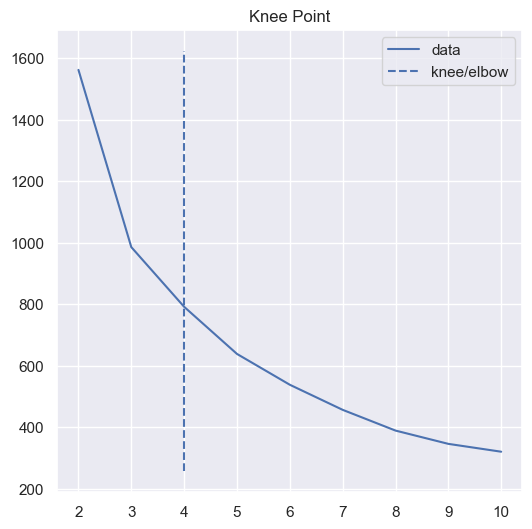

In [28]:
sse = []
for k in range(n, 11):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(rfm_df_scaled)
    sse.append(model.inertia_)

print(f"SSE : {sse}")

kl = KneeLocator(range(n, 11), sse, curve="convex", direction="decreasing")

print(f"k terbaik menurut metode WCSS : {kl.elbow}")
kl.plot_knee()

In [29]:
model = KMeans(n_clusters=4, n_init=10, random_state=42)
cluster_labels = model.fit_predict(rfm_df_scaled)
pd.DataFrame(cluster_labels).value_counts()

rfm_df["cluster"] = cluster_labels

In [30]:
rfm_df

,customer_id,recency,frequency_item_level,frequency_transaction_level,monetary,cluster
0,00a7dfd15e10cb728079fe35303dffbf,90,1,1,550000,0
1,00b998871ab191f24d36ed3992adfd71,332,1,1,780000,1
2,00df99c21eca2023839891960ff18929,212,1,1,195000,0
3,00f59b9f59b529efd9730b89c5b50120,151,1,1,585000,0
4,0125a0c6bdc03a50be051c4c8707249c,332,1,1,550000,1
...,...,...,...,...,...,...
847,fd64fd4a30385605da53606d34289ae4,151,1,1,730000,0
848,fddfc6052b6a137a6c896cd23df9ad0e,182,1,1,435000,0
849,fed0efe3530c5537df1a1696cfc9489d,120,1,1,435000,0
850,ff1fb072e91c4bed31b63719ce3325f7,273,1,1,195000,1


In [32]:
fig = px.scatter_3d(
    rfm_df, x="recency", y="frequency_item_level", z="monetary", color="cluster"
)
fig.show()

In [37]:
def plot_numerical_distribution(
    df,
    numerical_columns,
    title="Default Distribution Title",
    hue=None,
    kind="hist",
    savefig=False,
    savedir=Path.cwd(),
):
    sns.set_theme(style="white")

    column_size = len(numerical_columns)
    nrows = (column_size + 2) // 3  # Calculate number of rows needed for 3 columns

    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20, nrows * 6))

    axes = axes.flatten()

    if kind == "hist":
        for i, col in enumerate(numerical_columns):
            sns.histplot(df, x=col, ax=axes[i], kde=True, hue=hue)
            axes[i].set_title(f"{col}")
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")
            sns.despine(ax=axes[i], left=True)

    elif kind == "box":
        for i, col in enumerate(numerical_columns):
            sns.boxplot(df, x=col, ax=axes[i], hue=hue)
            axes[i].set_title(f"{col}")
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")
            sns.despine(ax=axes[i], left=True)

    else:
        raise ValueError("Invalid kind specified. Use 'hist' or 'box'.")

    for i in range(column_size, len(axes)):
        axes[i].axis("off")

    plt.suptitle(title, fontweight="bold", fontsize=18)
    plt.tight_layout(pad=2.0)

    if savefig:
        fig.savefig(
            savedir / f"{title}.jpg", bbox_inches="tight", pad_inches=0.5, dpi=300
        )

        print(f"figure successfully saved to {savedir / f'{title}.jpg'}")

    plt.show()

figure successfully saved to b:\Project\data-analysis\sales-fabsco-analysis\RFM Distribution.jpg


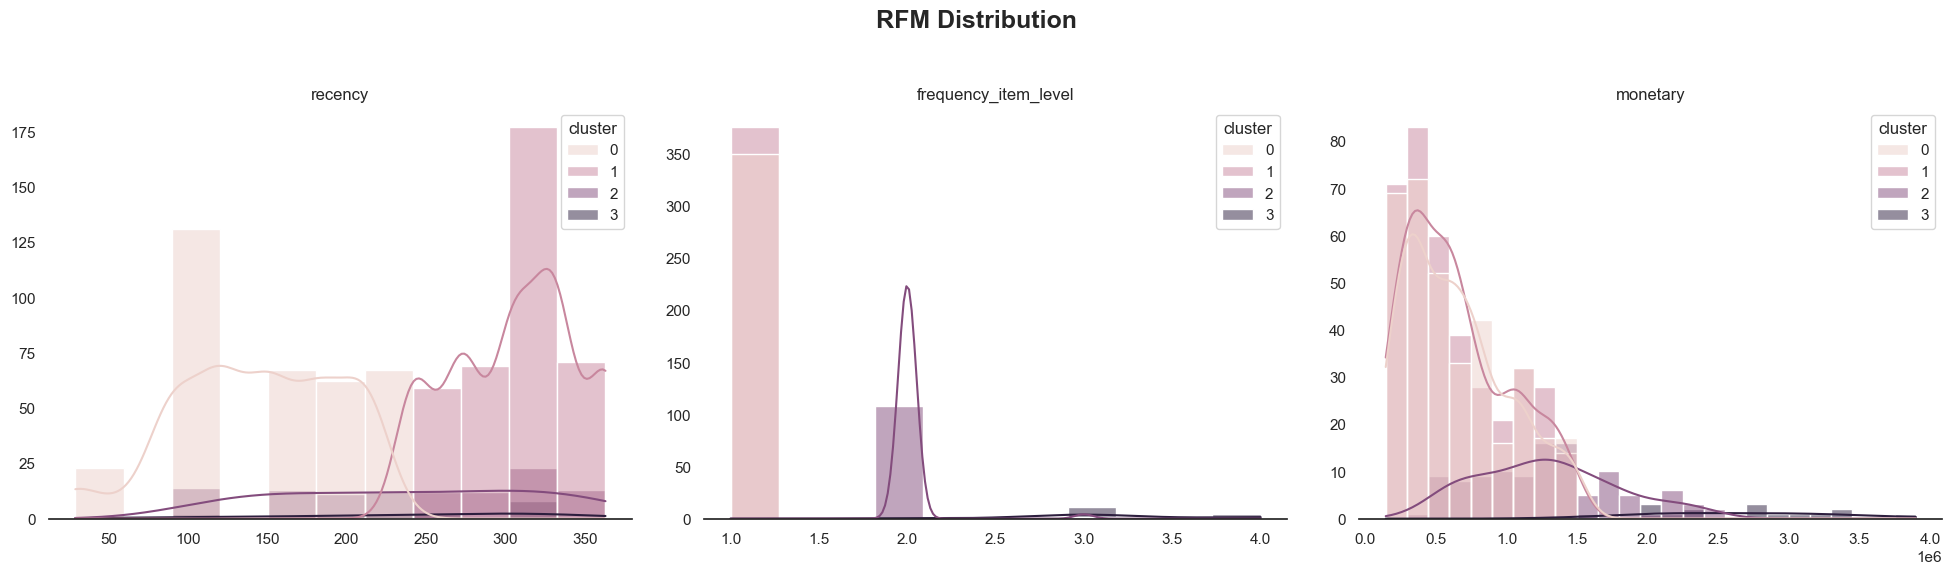

In [41]:
plot_numerical_distribution(
    rfm_df,
    featrues_to_use_1,
    "RFM Distribution",
    kind="hist",
    hue="cluster",
    savefig=True,
)

figure successfully saved to b:\Project\data-analysis\sales-fabsco-analysis\RFM Distribution (Box).jpg


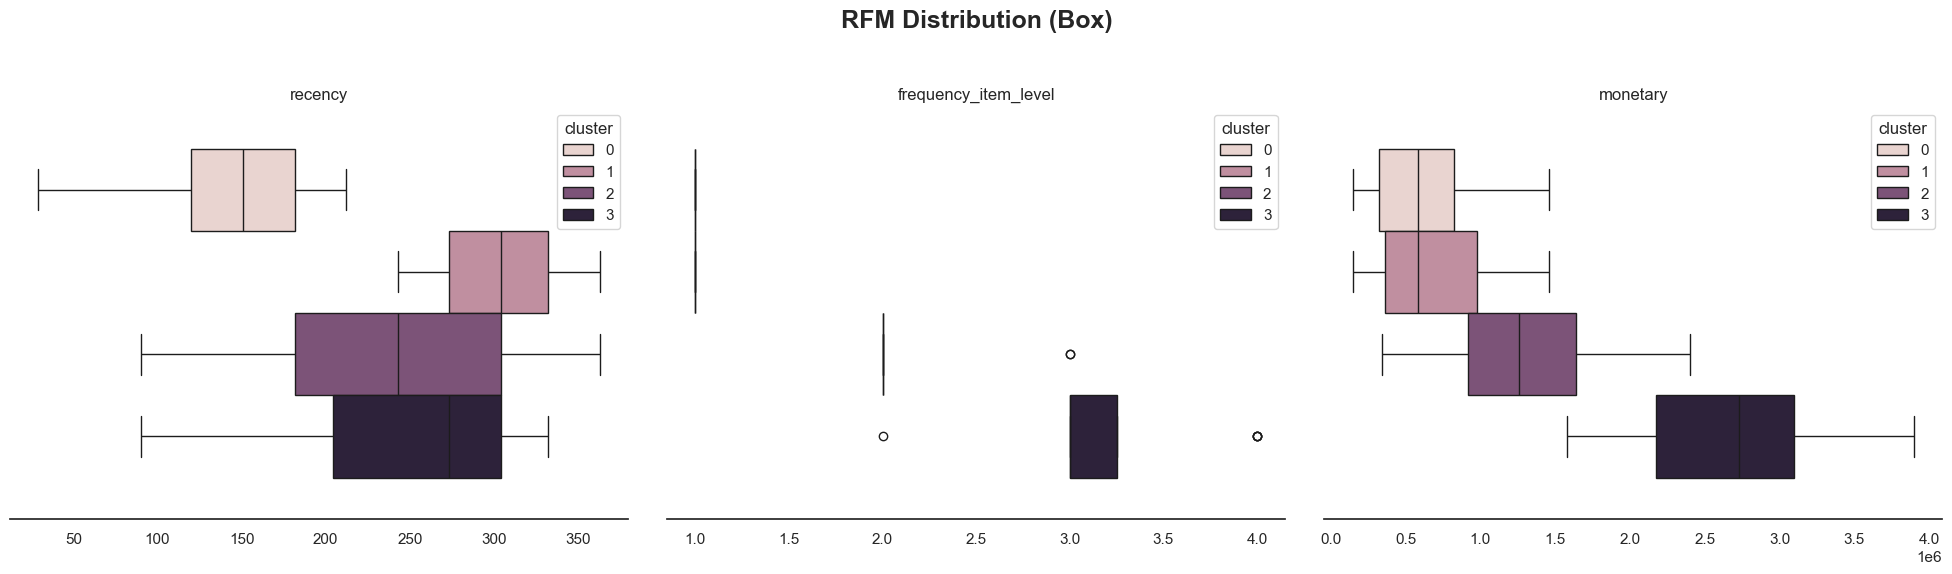

In [39]:
plot_numerical_distribution(
    rfm_df,
    featrues_to_use_1,
    "RFM Distribution (Box)",
    kind="box",
    hue="cluster",
    savefig=True,
)

Insight:
- Cluster 0: Pelanggan baru-baru ini aktif, tapi nilai dan frekuensi pembelian rendah → peluang untuk up-selling / cross-selling.
- Cluster 1: Pelanggan tidak terlalu aktif dan memiliki nilai pembelian rendah → butuh strategi re-engagement.
- Cluster 2: Pelanggan tidak terlalu aktif, tapi memiliki pembelian menengah → bisa diarahkan menjadi pelanggan premium dengan promosi tepat.
- Cluster 3: Pelanggan paling bernilai (high monetary & beberapa high frequency), tapi recency relatif lama → perlu dijaga agar tidak churn.